# classical MNIST dataset training and validation; feed-forward convolutional neuronal networks 

In [ ]:
import torch as pyt
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [ ]:
import torch.nn.functional as F

In [ ]:
!wget -nc -P . "https://hubur.org/download/prediction-challenge-01-data.npz"

--2020-05-13 19:44:02--  https://hubur.org/download/prediction-challenge-01-data.npz
Resolving hubur.org (hubur.org)... 77.111.240.4, 2a02:2350:5:108:4100:0:4457:f3e4
Connecting to hubur.org (hubur.org)|77.111.240.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5417154 (5.2M)
Saving to: ‘./prediction-challenge-01-data.npz’

prediction-challeng 100%[===================>]   5.17M  4.65MB/s    in 1.1s    

2020-05-13 19:44:04 (4.65 MB/s) - ‘./prediction-challenge-01-data.npz’ saved [5417154/5417154]



(20000, 1, 28, 28) float32
(20000,) int64
(2000, 1, 28, 28) float32


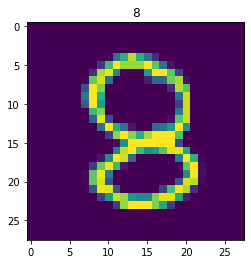

In [ ]:
with np.load('prediction-challenge-01-data.npz') as fh:
    data_x = fh['data_x']
    data_y = fh['data_y']
    test_x = fh['test_x']

# TRAINING DATA: INPUT (x) AND OUTPUT (y)
# 1. INDEX: IMAGE SERIAL NUMBER
# 2. INDEX: COLOR CHANNEL
# 3/4. INDEX: PIXEL VALUE
print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)

# TEST DATA: INPUT (x) ONLY
print(test_x.shape, test_x.dtype)

plt.imshow(data_x[0,0])
plt.title(data_y[0])
plt.show()

In [ ]:
def normalize(data, maxV):
    return data/maxV


x_norm = [normalize(image[0], 255) for image in data_x]
test_norm = [normalize(image[0], 255) for image in test_x]

In [ ]:
#generate valid data by randomly taking 10% of the data for a valid set
valid_x, valid_y = [], []
train_x, train_y = [], []
rnums = random.sample(range(0,20000), 2000)
for i in range(0,20000):
    if i in rnums:
        valid_x.append(x_norm[i])
        valid_y.append(data_y[i])#labels
        #train_x.append(x_norm[i]) only before submission when all hyperparameters are set
        #train_y.append(labels[i])
    else:
        train_x.append(x_norm[i])
        train_y.append(data_y[i])#labels
        
train_data = [train_x, train_y]
valid_data = [valid_x, valid_y]

len(train_x), len(train_y), len(valid_x), len(valid_y)


(18000, 18000, 2000, 2000)

In [ ]:
# to convert in numpy arrays
train_x_np=np.array(train_x)
train_y_np=np.array(train_y)
valid_x_np=np.array(valid_x)
valid_y_np=np.array(valid_y)
#print(train_x_np.shape)
(train_x_np.shape, train_y_np.shape), (valid_x_np.shape, valid_y_np.shape)

(((18000, 28, 28), (18000,)), ((2000, 28, 28), (2000,)))

In [ ]:
# converting training images into torch format
train_x_np = train_x_np.reshape(18000, 1, 28, 28)
train_x_np  = torch.from_numpy(train_x_np)

# converting the target into torch format
train_y_np = train_y_np.astype(int);
train_y_np = torch.from_numpy(train_y_np).type(torch.LongTensor)
#train_y_np = torch.from_numpy(train_y_np)

# shape of training data
train_x_np.shape, train_y_np.shape

(torch.Size([18000, 1, 28, 28]), torch.Size([18000]))

In [ ]:
# converting validation images into torch format
valid_x_np = valid_x_np.reshape(2000, 1, 28, 28)
valid_x_np  = torch.from_numpy(valid_x_np)

# converting the target into torch format
valid_y_np = valid_y_np.astype(int);
valid_y_np = torch.from_numpy(valid_y_np).type(torch.LongTensor)
#valid_y_np = torch.from_numpy(valid_y_np)

# shape of validation data
valid_x_np.shape, valid_y_np.shape

(torch.Size([2000, 1, 28, 28]), torch.Size([2000]))

In [ ]:
valid_y_np.type()

'torch.LongTensor'

In [ ]:
#CNN architecture with 2 convolutional layers to extract features from the images
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(4 * 7 * 7, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [ ]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
#criterion = F.nll_loss()
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=196, out_features=10, bias=True)
  )
)


In [ ]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x_np), Variable(train_y_np)
    # getting the validation set
    x_val, y_val = Variable(valid_x_np), Variable(valid_y_np)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        #y_train = torch.tensor(y_train, dtype=torch.long, device=device)
        #y_train = y_train.long()
        x_val = x_val.cuda()
        y_val = y_val.cuda()
        #y_val = torch.tensor(y_val, dtype=torch.long, device=device)
        #y_val = y_val.long()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [ ]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(2.6178, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  3 	 loss : tensor(6.3215, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  5 	 loss : tensor(3.1462, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  7 	 loss : tensor(1.7246, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  9 	 loss : tensor(1.7864, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  11 	 loss : tensor(1.5865, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  13 	 loss : tensor(1.3729, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  15 	 loss : tensor(1.1068, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  17 	 loss : tensor(0.9179, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  19 	 loss : tensor(0.8404, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  21 	 loss : tensor(0.7772, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  23 	 loss : tensor(0.6864, device='cuda:0', grad_fn=<NllLossBackward>)
Epoch :  25 	 loss : tensor(0.6372, device='c

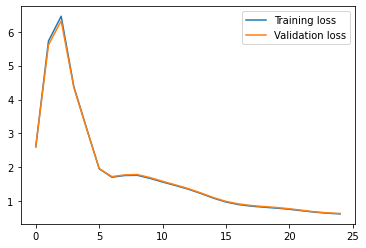

In [ ]:
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
# prediction for training set
with torch.no_grad():
    output = model(train_x_np.cuda())
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
accuracy_score(train_y_np, predictions)

0.8119444444444445

In [ ]:
# prediction for validation set
with torch.no_grad():
    output = model(valid_x_np.cuda())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
accuracy_score(valid_y_np, predictions)

0.806

In [ ]:
test_x_neu = []
for i in range(0,len(test_x)):
    test_x_neu.append(test_norm[i])

test_x_neu_np = np.array(test_x_neu)
test_x_neu_np.shape

(2000, 28, 28)

In [ ]:
# converting training images into torch format
test_x_tf = test_x_neu_np.reshape(2000, 1, 28, 28)
test_x_tf  = torch.from_numpy(test_x_tf)
test_x_tf.shape

torch.Size([2000, 1, 28, 28])

In [ ]:
# generating predictions for test set
with torch.no_grad():
    output = model(test_x_tf.cuda())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
prediction = np.argmax(prob, axis=1)

In [ ]:
# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction.ndim == 1
assert prediction.shape[0] == 2000

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('prediction.npy', prediction)

In [ ]:
np.load('prediction.npy')

array([9, 7, 7, ..., 4, 4, 0])

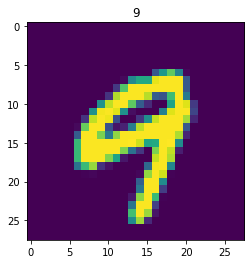

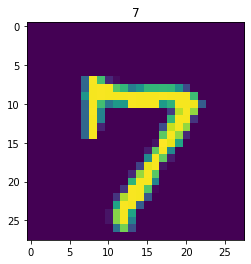

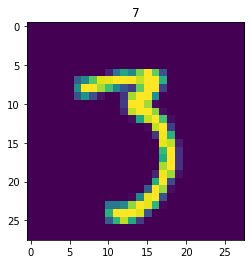

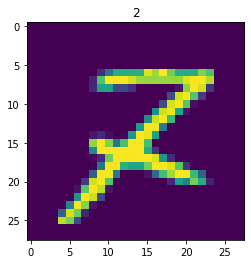

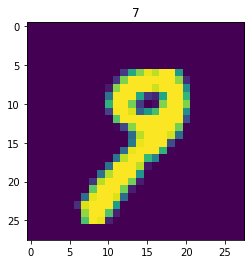

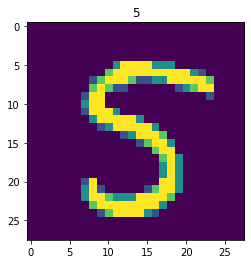

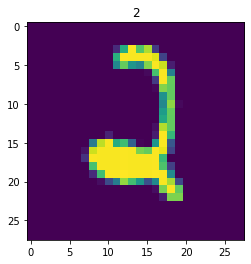

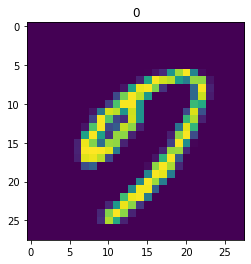

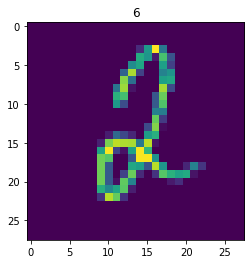

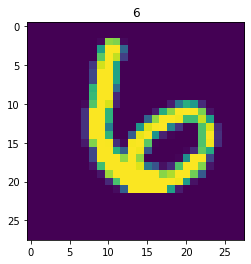

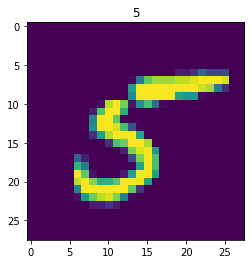

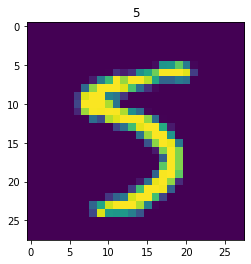

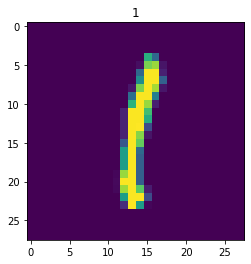

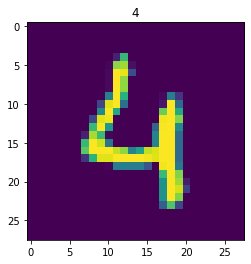

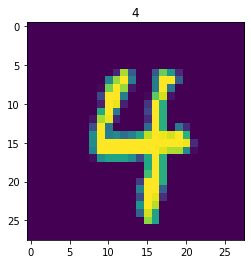

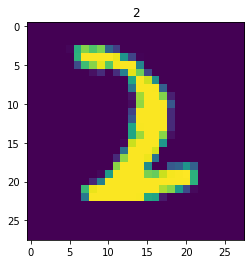

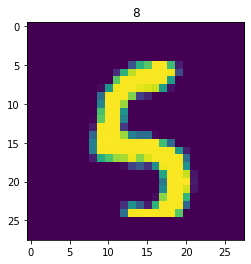

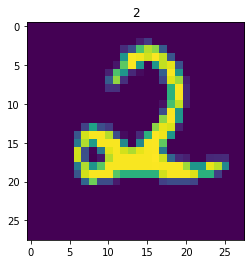

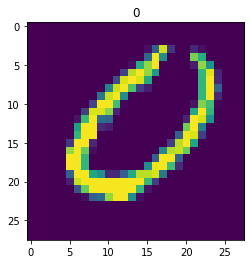

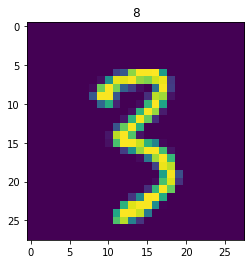

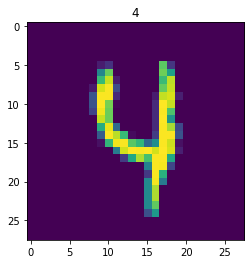

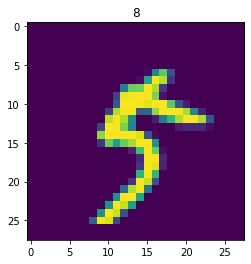

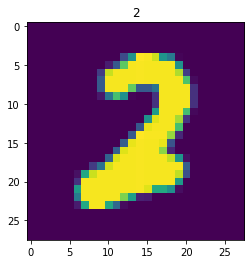

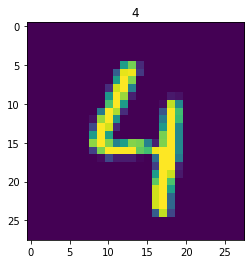

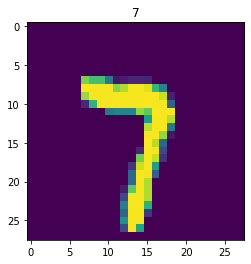

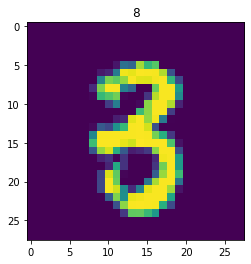

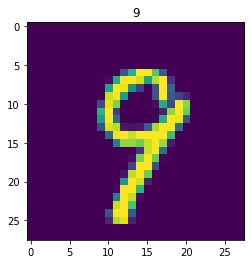

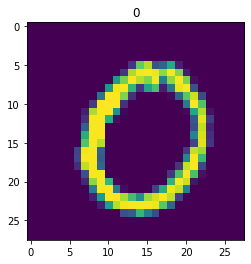

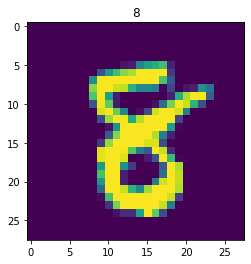

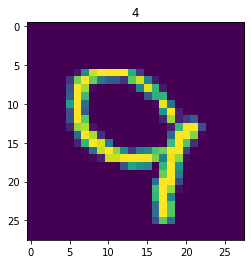

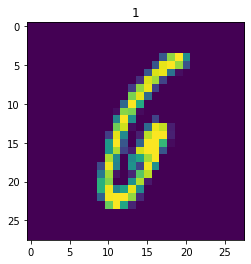

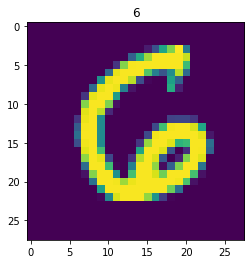

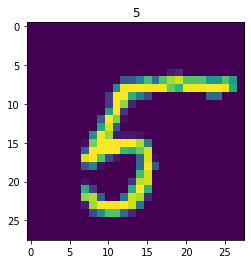

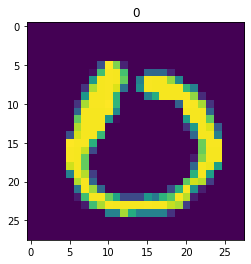

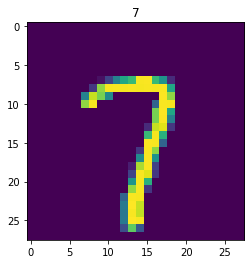

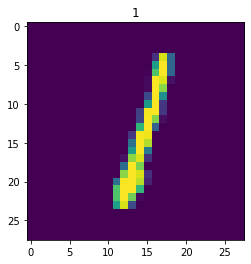

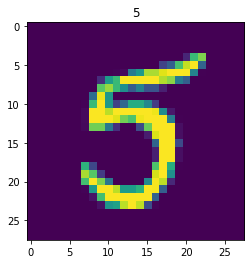

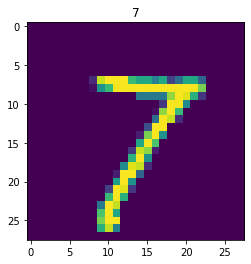

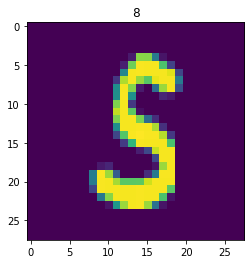

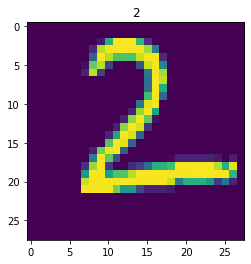

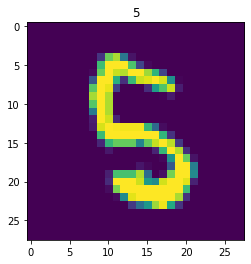

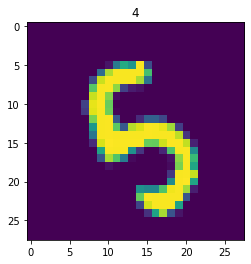

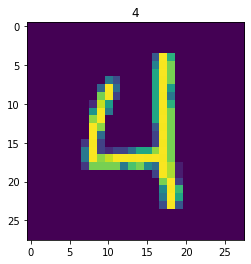

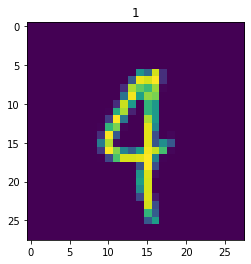

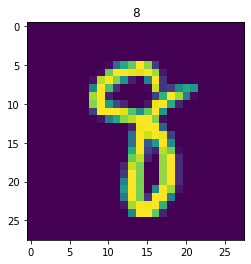

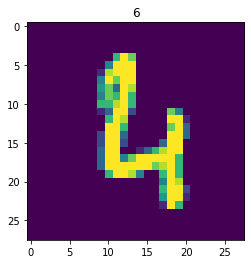

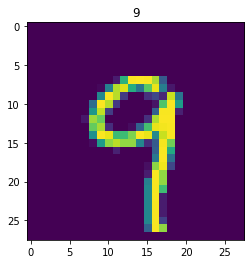

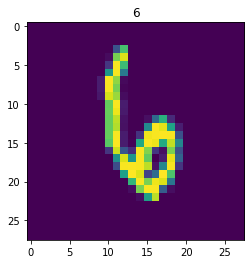

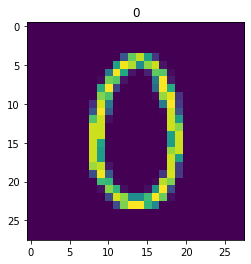

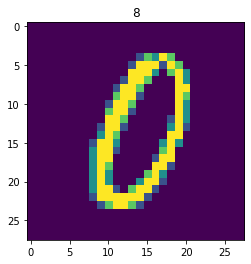

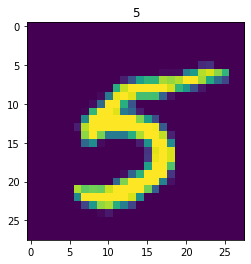

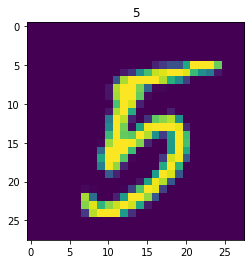

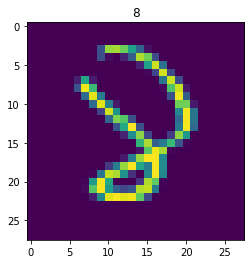

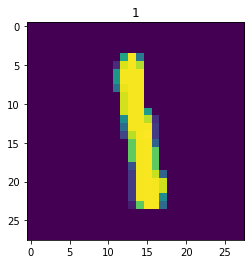

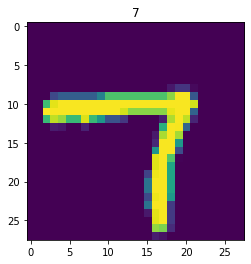

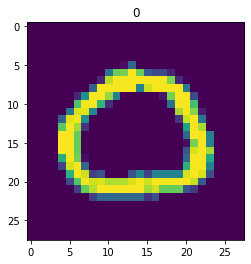

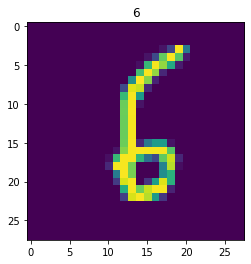

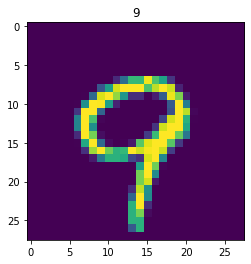

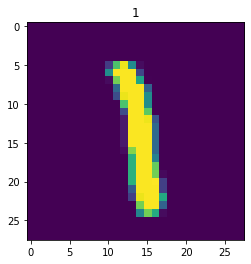

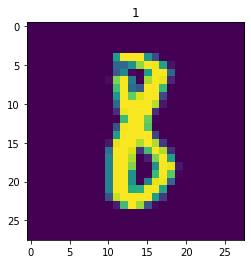

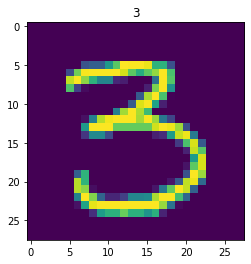

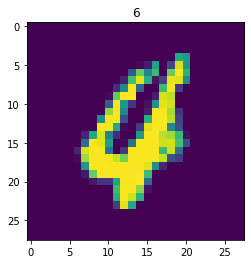

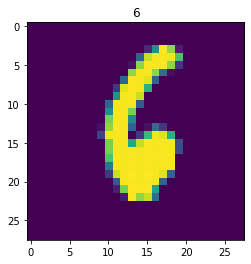

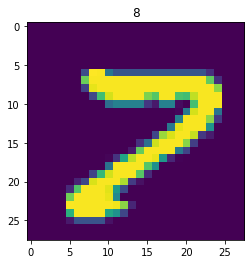

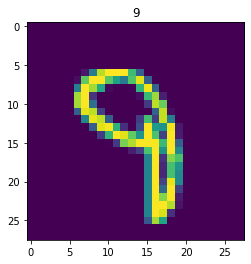

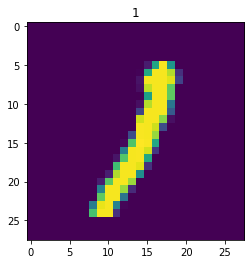

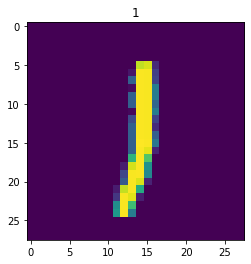

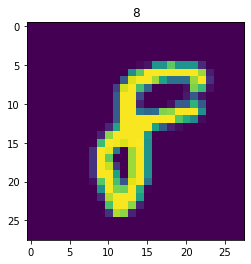

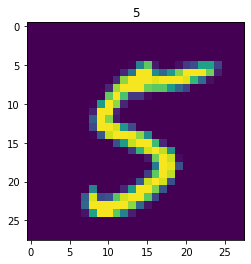

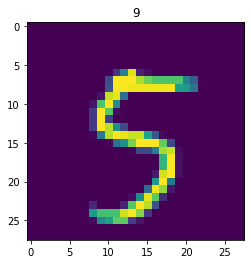

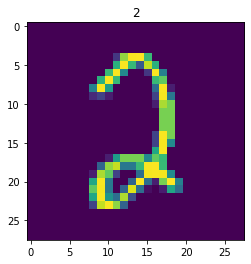

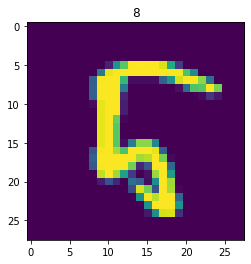

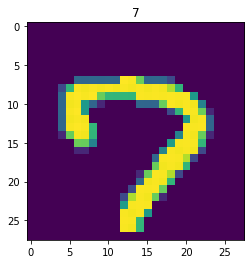

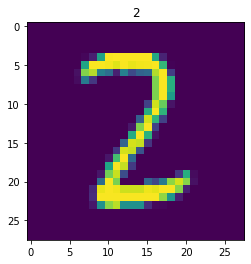

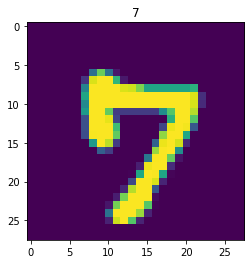

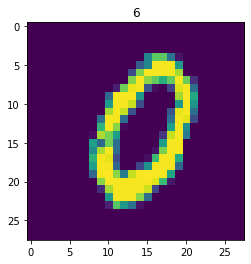

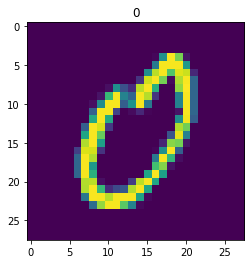

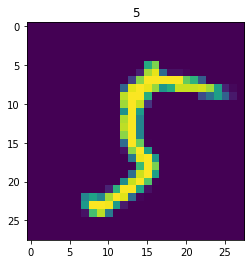

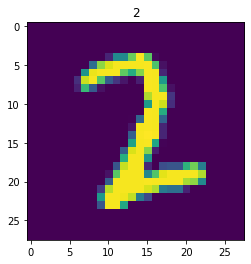

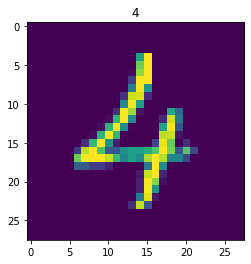

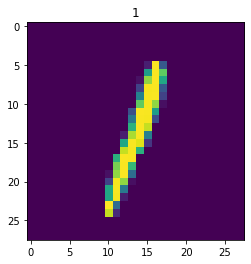

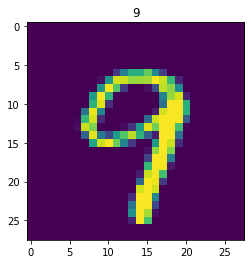

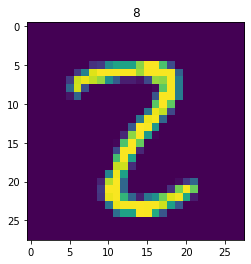

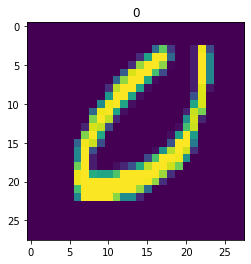

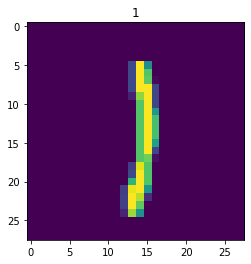

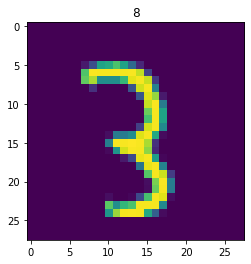

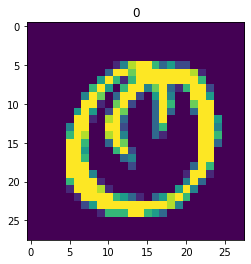

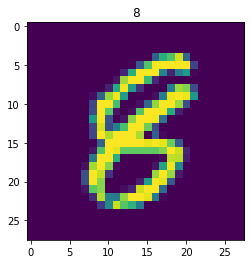

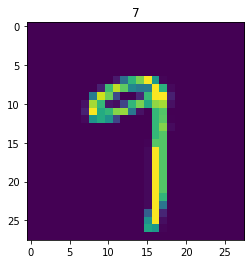

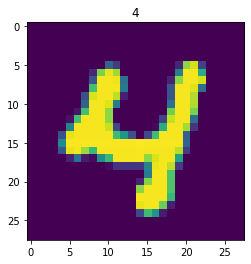

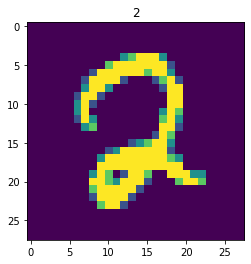

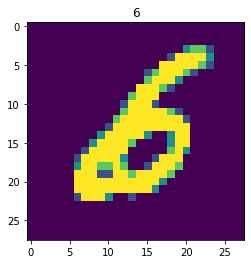

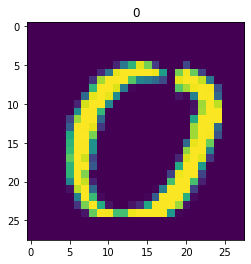

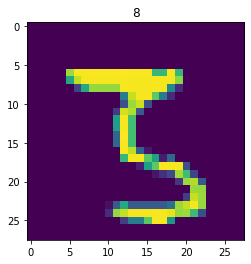

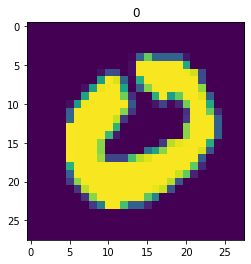

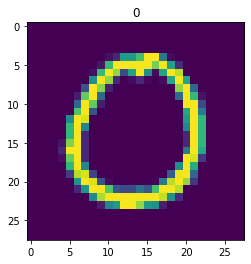

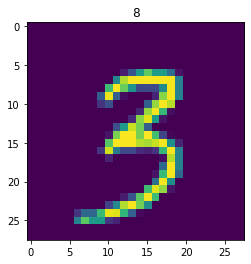

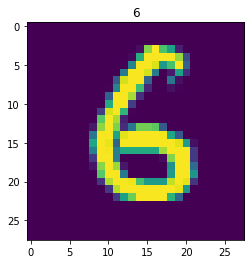

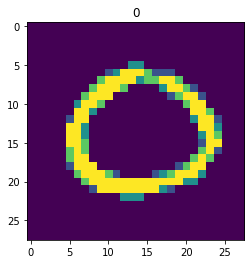

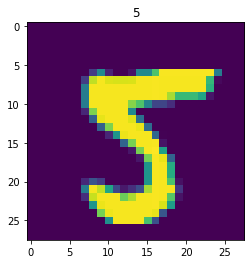

In [ ]:
for i in range(0,100):
    plt.imshow(test_norm[i])
    plt.title(prediction[i])
    plt.show()